## Binary Sentiment Classification

### Dataset
__Large Moview reviews Dataset__ <br>
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well. Raw text and already processed bag of words formats are provided. See the README file contained in the release for more details.

In [1]:
import io
import os
import torch
import configparser
from tqdm import tqdm
from torch.utils.data import Dataset,DataLoader
from transformers import (AutoConfig,
                          AutoModelForSequenceClassification,
                          AutoTokenizer,
                          AdamW,
                          get_linear_schedule_with_warmup,
                          set_seed
                          )
# from ftfy import fix_text
from ml_things import fix_text
import warnings

warnings.filterwarnings('ignore')

In [2]:
config = configparser.ConfigParser()
config.read('../config/config.ini')

['../config/config.ini']

In [3]:
seed = int(config['transformers']['seed'])
epochs = int(config['transformers']['epochs'])
batches = int(config['transformers']['batches'])
max_length = int(config['transformers']['max_sequence_length'])
model_name_path = config['transformers']['model_name_or_path']

In [4]:
model_name_path.replace('"', '')

'bert-base-cased'

In [5]:
set_seed(seed)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
print(f'Working on device: {device}, model: {torch.cuda.get_device_name(0)}')

Working on device: cuda, model: GeForce RTX 2060


In [8]:
label_ids = {'neg': 0, 'pos': 1}
n_labels = len(label_ids)

## Create Dataset class

In [9]:
class MovieReviewsDataset(Dataset):
    def __init__(self,
                 path,
                 use_tokenizer,
                 label_ids,
                 max_length=None):

        if not os.path.isdir(path):
            raise ValueError(f'Path: {path} not found')

        max_seq_len = use_tokenizer.max_len if max_length is None else max_length

        texts = []
        labels = []

        for label,label_id in tqdm(label_ids.items(),position=0, leave=True):
            
            sentiment_path = os.path.join(path,label)

            file_names = os.listdir(sentiment_path)
            print(f'Reading {label} files ')

            for file_name in file_names:
                
                file_path = os.path.join(sentiment_path,file_name)
                content = io.open(file_path, mode='r', encoding='utf-8').read()
                content = fix_text(content)
                texts.append(content)
                labels.append(label_id)

        self.n_examples = len(labels)

        print('Tokenizing all texts....')
        self.inputs = use_tokenizer(texts,add_special_tokens=True, truncation=True, padding=True, return_tensors='pt', max_length = max_seq_len)

        self.sequence_len = self.inputs['input_ids'].shape[-1]
        print(f'Max Sequence Length of Texts after Tokenization: {self.sequence_len}')
        
        self.inputs.update({'labels': torch.tensor(labels)})
        print('finished')

    
    def __len__(self):
        return self.n_examples

    def __getitem__(self, item):
        
        return {key: self.inputs[key][item] for key in self.inputs.keys()}

In [10]:
class Training:

    def __init__(self,data_loader,model,optimizer,scheduler,device):
        
        self.data_loader = data_loader
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device

    def train(self):
        
        self.model.train()
        losses = 0
        correct_predictions = 0
        predictions_labels = []
        true_labels = []

        for batch in tqdm(self.data_loader,total = len(self.data_loader),position=0, leave=True):
            
            true_labels += batch['labels'].numpy().flatten().tolist()
            batch = {k:v.type(torch.long).to(self.device) for k,v in batch.items()}

            model.zero_grad()

            outputs = model(**batch)
            loss,logits = outputs[:2]

            losses+= loss.item()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)

            optimizer.step()

            scheduler.step()

            logits = logits.detach().cpu().numpy()

            predictions_labels += logits.argmax(axis = -1).flatten().tolist()

        
        avg_epoch_loss = losses / len(self.data_loader)

        return true_labels, predictions_labels,avg_epoch_loss      


In [11]:
class Validation:

    def __init__(self,data_loader,model,device):
        
        self.data_loader = data_loader
        self.model = model
        self.device = device

    def validate(self):
        
        self.model.eval()
        losses = 0
        correct_predictions = 0
        predictions_labels = []
        true_labels = []

        for batch in tqdm(self.data_loader,total = len(self.data_loader),position=0, leave=True):
            
            true_labels += batch['labels'].numpy().flatten().tolist()
            batch = {k:v.type(torch.long).to(self.device) for k,v in batch.items()}

            with torch.no_grad():

                outputs = model(**batch)
                loss,logits = outputs[:2]

                losses+= loss.item()
                
                logits = logits.detach().cpu().numpy()

                predictions_labels += logits.argmax(axis = -1).flatten().tolist()

        
        avg_epoch_loss = losses / len(self.data_loader)

        return true_labels, predictions_labels,avg_epoch_loss      


In [12]:
model_config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name_path,
                                          num_labels = n_labels)

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path = model_name_path)

model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path = model_name_path,
                                                            config = model_config)

model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [13]:
train_dataset = MovieReviewsDataset(path = '../Data/train', #os.path.join('..','Data','train'),
                                    use_tokenizer=tokenizer,
                                    label_ids = label_ids,
                                    max_length= max_length)

train_data_loader = DataLoader(train_dataset,batch_size=batches,shuffle=True)

validation_dataset = MovieReviewsDataset(path = os.path.join('..','Data','test'),
                                    use_tokenizer=tokenizer,
                                    label_ids = label_ids,
                                    max_length= max_length)

validation_data_loader = DataLoader(train_dataset,batch_size=batches,shuffle=False)

100%|██████████| 2/2 [00:17<00:00,  8.62s/it]
Tokenizing all texts....
  0%|          | 0/2 [00:00<?, ?it/s]Max Sequence Length of Texts after Tokenization: 100
finished
Reading neg files 
100%|██████████| 2/2 [00:16<00:00,  8.29s/it]
Tokenizing all texts....
Max Sequence Length of Texts after Tokenization: 100
finished


## Training

In [14]:
from sklearn.metrics import accuracy_score

optimizer = AdamW(model.parameters(),
                lr = 2e-5,
                eps = 1e-8)

total_steps = len(train_dataset)*epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps= total_steps)



trainer = Training(data_loader = train_data_loader,
                   model = model,
                   optimizer = optimizer,
                   scheduler = scheduler,
                   device = device)

validator = Validation(data_loader = train_data_loader,
                       model = model,
                       device = device
                       )

best_accuracy = 0

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

for epoch in tqdm(range(epochs),position=0, leave=True):

    train_labels,train_predictions,training_loss = trainer.train()
    training_accuracy = accuracy_score(train_labels,train_predictions)
    print(f'Training loss for epoch {epoch+1}: {training_loss}' )

    validation_labels,validation_predictions,validation_loss = validator.validate()
    validation_accuracy = accuracy_score(validation_labels,validation_predictions)
    print(f'Validation loss for epoch {epoch+1}: {validation_loss}' )

    if validation_accuracy > best_accuracy:
        torch.save(model.state_dict(),os.path.join('..','model','best_model.bin'))
        best_accuracy = validation_accuracy

    # Store the loss value for plotting the learning curve.
    all_loss['train_loss'].append(training_loss)
    all_loss['val_loss'].append(validation_loss)
    all_acc['train_acc'].append(training_accuracy)
    all_acc['val_acc'].append(validation_accuracy)

print(f'Best Accuracy achieved: {best_accuracy}')

100%|██████████| 3125/3125 [02:36<00:00, 20.00it/s]
Validation loss for epoch 1: 0.23341360479816795
100%|██████████| 3125/3125 [02:35<00:00, 20.10it/s]
Validation loss for epoch 2: 0.11855626001197844
100%|██████████| 3125/3125 [02:34<00:00, 20.23it/s]
Validation loss for epoch 3: 0.057188991209827365
100%|██████████| 3125/3125 [02:39<00:00, 19.58it/s]
Validation loss for epoch 4: 0.02887791697099805
100%|██████████| 4/4 [50:32<00:00, 758.05s/it]Best Accuracy achieved: 0.99404



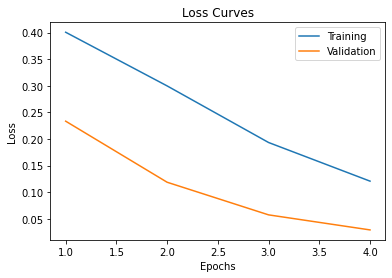

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
sns.lineplot(x= [x for x in range(1,epochs+1)],y = all_loss['train_loss'])
sns.lineplot(x= [x for x in range(1,epochs+1)],y = all_loss['val_loss'])
plt.legend(['Training','Validation'])
plt.show()

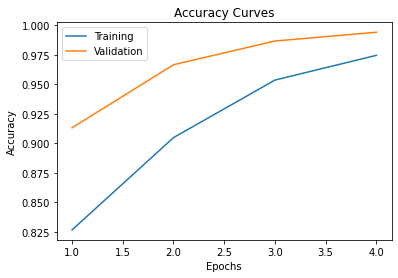

In [39]:
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
sns.lineplot(x= [x for x in range(1,epochs+1)],y = all_acc['train_acc'])
sns.lineplot(x= [x for x in range(1,epochs+1)],y = all_acc['val_acc'])
plt.legend(['Training','Validation'])
plt.show()